
# **Class Incremental Learning of the GTSRB Dataset**


***MACHINE LEARNING PROJECT :***
***Ahmadagha HAJIBALAYEV ,***
***Richard MUGERWA***


## **Introduction**

The German Traffic Sign Recognition Benchmark (GTSRB) dataset is a well-known dataset used for the task of recognizing images of road signs. The dataset consists of small-sized images (32x32 pixels) and is relatively small in terms of the number of data points, making it suitable for training deep networks on a good CPU within a reasonable time frame, though GPUs can significantly speed up the process.

The primary objective of this project is to address the challenge of class-incremental learning, where new categories (road signs) are introduced sequentially to the recognition system. This setting is particularly challenging because it often leads to "catastrophic forgetting," where the model forgets previously learned categories when new ones are added. To mitigate this issue, several strategies can be employed, including:

- **Rehearsal**: Maintaining a small memory buffer of previous examples to retain knowledge of old categories.
- **Regularization**: Techniques like Knowledge Distillation and Elastic Weight Consolidation (EWC) to prevent the model from forgetting old categories.
- **Incremental Architecture**: Modifying the network architecture to accommodate new classes without disrupting the learned representations of old classes.

The project aims to explore these strategies and evaluate their effectiveness in maintaining the model's performance as new classes are introduced. The goal is to develop a solution that can incrementally learn new categories while minimizing the impact of catastrophic forgetting, thereby maintaining high accuracy across all classes over time.



Our Project consist of 2 different methods and plots of both of them are added to the file.


In [2]:
####################################
### Useful imports
############################

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision.utils import make_grid
from torchvision import transforms, datasets
import torchvision.models as models
from torchvision.transforms import v2
import copy

import numpy as np
import random
import time, os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
# # Useful if you want to store intermediate results on your drive
from google.colab import drive

# # Useful if you want to store intermediate results on your drive from google.colab import drive

drive.mount('/content/gdrive/')
DATA_DIR =  '/content/gdrive/MyDrive/teaching/ENSTA/2024'


Mounted at /content/gdrive/


In [4]:
# Check if GPU is available
if torch.cuda.is_available():
  !nvidia-smi

Sat Mar 22 12:26:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Data loaders
The project begins with loading the GTSRB dataset using the torchvision library. The dataset is split into training and test sets, and appropriate transformations are applied to the images, such as resizing and normalization.

In [5]:
# Define transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    #transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669))
])

transform_train = v2.Compose([
    #v2.Grayscale(),
    #v2.RandomResizedCrop(32),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

transform_test = v2.Compose([
    #v2.Grayscale(),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

# Define dataset and dataloader
def get_dataset(root_dir, transform, train=True):
    dataset = datasets.GTSRB(root=root_dir, split='train' if train else 'test', download=True, transform=transform)
    target = [data[1] for data in dataset]
    return dataset, target

def create_dataloader(dataset, targets, current_classes, batch_size, shuffle):
    indices = [i for i, label in enumerate(targets) if label in current_classes]
    subset = Subset(dataset, indices)
    dataloader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


In [6]:
# Loads datasets (on your local computer)
root_dir = '/home/stephane/Documents/Onera/Cours/ENSTA/2025/data'

# Loads datasets (on Colab local computer)
root_dir = './data'

train_dataset = datasets.GTSRB(root=root_dir, split='train', download=True, transform=transform_train)
test_dataset = datasets.GTSRB(root=root_dir, split='test', download=True, transform=transform_test)

print(f"Train dataset contains {len(train_dataset)} images")
print(f"Test dataset contains {len(test_dataset)} images")

# Loads target id lists and class names (not in torchvision dataset)
import csv
data = pd.read_csv('https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/IOGS/projet/test_target.csv', delimiter=',', header=None)
test_target = data.to_numpy().squeeze().tolist()

data = pd.read_csv('https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/IOGS/projet/train_target.csv', delimiter=',', header=None)
train_target = data.to_numpy().squeeze().tolist()

data = pd.read_csv('https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/IOGS/projet/signnames.csv')
class_names = data['SignName'].tolist()

100%|██████████| 187M/187M [00:09<00:00, 20.8MB/s]
100%|██████████| 89.0M/89.0M [00:04<00:00, 17.9MB/s]
100%|██████████| 99.6k/99.6k [00:00<00:00, 191kB/s]


Train dataset contains 26640 images
Test dataset contains 12630 images


## Display of images

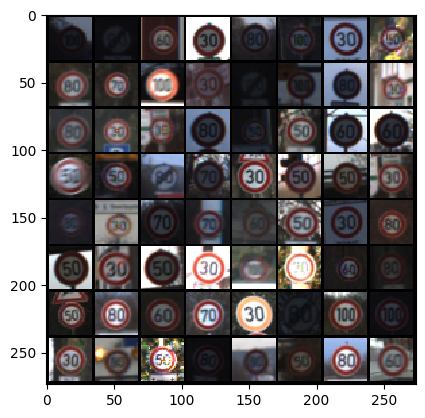

torch.Size([64, 3, 32, 32])


In [7]:
nclasses = len(np.unique(train_target))
all_classes = list(range(nclasses))
#random.shuffle(all_classes)
classes_per_task = 8
current_classes = []

task = 0
task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
current_classes.extend(task_classes)
batch_size = 64

# Create data for first task
train_loader = create_dataloader(train_dataset, train_target, current_classes, batch_size, shuffle = True)
test_loader = create_dataloader(train_dataset, train_target, current_classes, batch_size, shuffle = True)

# Displays a few examples
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

sample,targets = next(iter(train_loader))
show(make_grid(sample))
plt.show()

print(sample.shape)     ## 64 is the batch
                        ## 1 for grey values --  3 for RGB
                        ## 32x32 for mage size (small here)


In [8]:
test_loader = create_dataloader(train_dataset, train_target, all_classes, batch_size, shuffle = True)

# Get the data from the test set and computes statistics
# gtsrbtest_gt = []
# for _, targets in test_loader:
#   gtsrbtest_gt += targets.numpy().tolist()
# print(len(gtsrbtest_gt))

from collections import Counter

label_counts = Counter(test_target).most_common()
for l, c in label_counts:
    print(c, '\t', l, '\t', class_names[l])

750 	 2 	 Speed limit (50km/h)
720 	 1 	 Speed limit (30km/h)
720 	 13 	 Yield
690 	 38 	 Keep right
690 	 12 	 Priority road
660 	 4 	 Speed limit (70km/h)
660 	 10 	 No passing for vechiles over 3.5 metric tons
630 	 5 	 Speed limit (80km/h)
480 	 25 	 Road work
480 	 9 	 No passing
450 	 7 	 Speed limit (100km/h)
450 	 3 	 Speed limit (60km/h)
450 	 8 	 Speed limit (120km/h)
420 	 11 	 Right-of-way at the next intersection
390 	 18 	 General caution
390 	 35 	 Ahead only
360 	 17 	 No entry
270 	 14 	 Stop
270 	 31 	 Wild animals crossing
210 	 33 	 Turn right ahead
210 	 15 	 No vechiles
180 	 26 	 Traffic signals
150 	 16 	 Vechiles over 3.5 metric tons prohibited
150 	 23 	 Slippery road
150 	 30 	 Beware of ice/snow
150 	 28 	 Children crossing
150 	 6 	 End of speed limit (80km/h)
120 	 34 	 Turn left ahead
120 	 22 	 Bumpy road
120 	 36 	 Go straight or right
90 	 21 	 Double curve
90 	 20 	 Dangerous curve to the right
90 	 24 	 Road narrows on the right
90 	 29 	 Bicycles cr

## Simple networks
A deep neural network is defined for the classification task. The network architecture is designed to handle the small image size and the number of classes in the GTSRB dataset.

In [9]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self,n_out=10, n_in=1):
        super().__init__()

        # Put the layers here
        self.conv1 = nn.Conv2d(n_in, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.fc = nn.Linear(4096, n_out)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x)) ## l'image 1x32x32 devient 32x32x32
        x = F.max_pool2d(x, kernel_size=2, stride=2) ## puis 32x16x16
        x = F.leaky_relu(self.conv2(x)) ## puis devient 64x16x16
        x = F.max_pool2d(x, kernel_size=2, stride=2) ## puis devient 64x8x8
        x = F.leaky_relu(self.conv3(x)) ## pas de changement

        x = x.view(-1,4096) ## 64x8x8 devient 4096

        x = self.fc(x) ## on finit exactement de la même façon

        return x

# Another simple model (compare them using torchinfo below)
class SimpleCNN2(nn.Module):
    def __init__(self, n_out=10, n_in=1):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(n_in, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc = nn.Linear(128, n_out)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc(x)
        return x

In [10]:
!pip install torchinfo
from torchinfo import summary

model = SimpleCNN2(n_out=10, n_in=3)
model.to(device)
print(summary(model, input_size=(batch_size, 3, 32, 32)))

model = SimpleCNN(n_out=10, n_in=3)
model.to(device)
print(summary(model, input_size=(batch_size, 3, 32, 32)))

#print(model)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN2                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 32, 32]          896
├─ReLU: 1-2                              [64, 32, 32, 32]          --
├─MaxPool2d: 1-3                         [64, 32, 16, 16]          --
├─Conv2d: 1-4                            [64, 64, 16, 16]          18,496
├─ReLU: 1-5                              [64, 64, 16, 16]          --
├─MaxPool2d: 1-6                         [64, 64, 8, 8]            --
├─Linear: 1-7                            [64, 128]                 524,416
├─ReLU: 1-8                              [64, 128]                 --
├─Linear: 1-9                            [64, 10]                  1,290
Total params: 545,098
Trainable params: 545,098
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 395.40
Input size (MB): 0.79
Forward/backward pass size (MB): 25.24
Params size (MB): 2.18
Estimated Tota

## Baseline for incremental learning

This section implements the **training, evaluation, and weight initialization** for class-incremental learning on the **GTSRB dataset**. The goal is to train a model sequentially on new traffic sign classes while retaining knowledge of previously learned classes.  

#### **1. Evaluation (`evaluate`)**  
- Assesses model accuracy on the test dataset after each learning phase.  
- Uses `torch.no_grad()` for efficient inference.  

#### **2. Training (`train`)**  
- Optimizes the model using **Cross-Entropy Loss** and **SGD/Adam optimizers**.  
- Adjusts learning rate dynamically with `StepLR` scheduler.  

#### **3. Weight Initialization (`initialize_weights`)**  
- Uses **Xavier initialization** for stability and faster convergence.  

#### **4. Incremental Learning (`incremental_learning`)**  
- Sequentially learns `classes_per_task` new classes over `num_tasks` iterations.  
- Expands the classifier output layer while **preserving previously learned weights**.  
- Uses **rehearsal + knowledge distillation** to mitigate **catastrophic forgetting**.  
- Tracks accuracy on both **new and old classes** after each task.  

By the end of training, the model adapts to all seen classes while minimizing forgetting. The **incremental accuracy graph** visualizes the performance across tasks.

In [11]:
from torch.optim import lr_scheduler
import torch.nn.init as init

# Evaluation
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, ncols=80):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Simple Training loop
def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()

    for images, labels in tqdm(train_loader, ncols=80,  desc="Epoch {}".format(epoch)):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def initialize_weights(module):
    """Initializes the weights of a PyTorch module using Xavier/Glorot initialization."""
    if isinstance(module, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):  # Check for relevant layers
        init.xavier_uniform_(module.weight) #Xavier uniform initialization
        if module.bias is not None:
            init.zeros_(module.bias)  # Initialize bias to zero
    elif isinstance(module, (nn.BatchNorm2d, nn.LayerNorm, nn.GroupNorm)): #Initialize normalization layers
        if module.weight is not None:
            init.ones_(module.weight)
        if module.bias is not None:
            init.zeros_(module.bias)


# Main training loop for incremental learning
def incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                         num_tasks, classes_per_task, batch_size, num_epochs, lr, device):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    current_classes = []
    accuracies = []

    for task in range(num_tasks):
        task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
        current_classes.extend(task_classes)

        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle = True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle = False)

        if task == 0:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        for epoch in range(num_epochs): # Adjust number of epochs as needed
            train(model, train_loader, optimizer, criterion, device, epoch)
            scheduler.step()
            accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy:.2f}%")
        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")

    return accuracies



## Weight & Biases

### **Incremental Learning with Weights & Biases (WandB) Logging**  

This section extends the incremental learning framework by **integrating Weights & Biases (WandB)** for experiment tracking, visualization, and performance monitoring.  

#### **1. Training with WandB (`train_wandb`)**  
- Implements a standard **training loop** with batch-wise loss computation.  
- Logs **training loss metrics** to WandB for real-time visualization.  
- Uses `wandb.log(metrics)` to track training loss per batch.  

#### **2. Incremental Learning with WandB (`incremental_learning_wandb`)**  
- Learns `classes_per_task` **incrementally**, updating the model’s classifier for new tasks.  
- Supports **two modes**:
  - **Incremental learning**: Learns new classes progressively.  
  - **Non-incremental learning**: Trains on all available data at once.  
- Expands the classifier **without forgetting previous weights**.  
- Logs **task-wise accuracy metrics** to WandB for better insights into model performance.  

#### **3. WandB Metrics & Experiment Tracking**  
- Defines custom tracking metrics:
  - `"train/train_loss"` – Tracks training loss over epochs.  
  - `"val/val_accuracy"` – Tracks validation accuracy per task.  
  - `"incremental_accuracy"` – Tracks accuracy evolution across tasks.  
- Helps **visualize catastrophic forgetting** and compare incremental vs. non-incremental learning.  



In [12]:
###################################
##### For using Weight & Biases
###############

!pip install wandb -qU

import wandb

wandb.login()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ahmadagha-hajibalayev (ahmadagha-hajibalayev-fr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [13]:
import math
# Simple Training loop
def train_wandb(model, train_loader, optimizer, criterion, device, epoch):

    step_ct = 0
    n_steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)

    model.train()

    for step, (images, labels) in tqdm(enumerate(train_loader), ncols=80,  desc="Epoch {}".format(epoch)):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        metrics = {"train/train_loss": loss}
        # metrics = {"train/train_loss": loss,
        #             "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch}

        if step + 1 < n_steps_per_epoch:
          # Log train metrics to wandb
          wandb.log(metrics)
        step_ct += 1


# Main training loop for incremental learning
def incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                         num_tasks, classes_per_task, batch_size, num_epochs, lr, device, non_incremental = False):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    current_classes = []
    accuracies = []

    # Copy your config
    config = wandb.config

    wandb.define_metric("task")
    wandb.define_metric("incremental_accuracy", step_metric="task")

    for task in range(num_tasks):
        if non_incremental == True: # Learn from all available data
          task_classes = all_classes[0 : (task + 1) * classes_per_task]
          current_classes = task_classes
          model.apply(initialize_weights)
        else:
          task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
          current_classes.extend(task_classes)

        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle = True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle = False)

        if task == 0 or non_incremental == True:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        for epoch in range(num_epochs): # Adjust number of epochs
            #train(model, train_loader, optimizer, criterion, device, epoch)

            # If logging training (but not incremental)
            train_wandb(model, train_loader, optimizer, criterion, device, epoch)

            scheduler.step()
            accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy:.2f}%")

            val_metrics = {"val/val_accuracy": accuracy}
            #wandb.log({**val_metrics})

        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")

        incremental_metrics = {"incremental_accuracy": accuracy, "task": task}
        wandb.log({**incremental_metrics})

        # Log train and validation metrics to wandb

    return accuracies



## Pre-Training

### **Hyperparameters & Pre-training Strategy**  

This section **defines the hyperparameters** and sets up **pre-training** for incremental learning on the GTSRB dataset.  

#### **1. Hyperparameter Setup**  
- **Dataset Path (`root_dir`)**: Specifies where the GTSRB dataset is stored.  
- **Number of Tasks (`num_tasks`)**: The dataset is split into `num_tasks = 5` incremental learning steps.  
- **Classes Per Task (`classes_per_task`)**: The total number of classes (`43`) is divided across tasks (~8-9 classes per task).  
- **Batch Size (`batch_size`)**: Set to `64`, balancing memory usage and training stability.  
- **Learning Rate (`lr`)**: `1e-3` for stable gradient descent updates.  
- **Training Device (`device`)**: Uses **CUDA** (GPU) if available, otherwise defaults to CPU.  

Additional parameters:  
- **`buffer_size = 200`** → Controls the rehearsal memory size for replay-based incremental learning.  
- **`alignment_strength = 0.1`** → Adjusts weight alignment strength for regularization.  
- **`num_epochs = 4`** → Initial pre-training is performed for **4 epochs** before switching to incremental learning.  

#### **2. Pre-training the Model**  
- A **pre-trained network** (`simpleCNN_GTSRB_pretrained`) is **loaded if available**.  
- If a pre-trained model exists, it is loaded and transferred to `device`.  
- Otherwise, a new **`SimpleCNN` model** is initialized and trained on the **first batch of classes** (`classes_per_task`).  
- The model is then saved using `torch.save(model.state_dict(), netname)`.  

#### **3. Model Copy for Comparison**  
- A **deep copy of the model** (`copy_model`) is created to ensure **consistent initialization** for later experiments.  
- The number of epochs is **reduced to 1** for incremental learning to speed up training.  

This setup ensures that the model **starts from a stable pre-trained state** before progressing to **incremental learning**.


In [14]:
# Hyperparameters
root_dir = './data'  # Path to GTSRB dataset
num_tasks = 5
numclasses = len(np.unique(train_target))
classes_per_task = numclasses // num_tasks #43/2 ~ 20
batch_size = 64
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

buffer_size = 200 # Adjust rehearsal set size
alignment_strength = 0.1 # Adjust alignment strength
num_epochs = 4

#model = SimpleCNN(n_out = 1, n_in = 3).to(device)
#model.apply(initialize_weights)

# The name of the network (choose the on you want)
tag = "simpleCNN_GTSRB_pretrained"
netname = os.path.join(root_dir, 'network_{:s}.pth'.format(tag))

#################################################
## Pre-training
####

# Read the last learned network (if stored)
if (os.path.exists(netname)):
    print('Load pre-trained network')
    model = SimpleCNN(n_in = 3, n_out=classes_per_task)
    model.load_state_dict(torch.load(netname,weights_only=True))

    #model = torch.load(netname, weights_only=True)
    model = model.to(device)
else:
    print('Pretrain')
    model = SimpleCNN(n_in = 3, n_out=1)
    model.apply(initialize_weights)
    model.to(device)

    accu = incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                        1, classes_per_task, batch_size, num_epochs, lr, device)

    print(f"!!!!! Pre-training on first task  = {accu[0]:.2f}%")

    # Save last learned model
    #torch.save(model, netname)
    torch.save(model.state_dict(), netname)

## Copy model to have the same initialization
copy_model = copy.deepcopy(model) # Copy model to start from the same initialization

#### Learn with a single epoch in incremental (faster but less accurate)
num_epochs = 1


Pretrain
Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7]


100%|█████████████████████████████████████████| 125/125 [00:10<00:00, 12.49it/s]


Task 1, Epoch 1: Accuracy Train = 66.60%


100%|█████████████████████████████████████████| 125/125 [00:04<00:00, 26.57it/s]


Task 1, Epoch 2: Accuracy Train = 86.91%


100%|█████████████████████████████████████████| 125/125 [00:03<00:00, 35.25it/s]


Task 1, Epoch 3: Accuracy Train = 93.69%


100%|█████████████████████████████████████████| 125/125 [00:04<00:00, 30.29it/s]


Task 1, Epoch 4: Accuracy Train = 98.11%


100%|███████████████████████████████████████████| 61/61 [00:01<00:00, 34.32it/s]

Task 1: Accuracy Test = 88.58%
!!!!! Pre-training on first task  = 88.58%


## Fine tuning

### **Fine-Tuning with Weights & Biases (WandB)**
  
This section **performs fine-tuning** using **Weights & Biases (WandB)** to track incremental learning progress.  

#### **1. Initialize WandB Run**  
- **Project Name (`GTSRB-CIL`)**: Defines a tracking project in WandB.  
- **Run Name (`Fine tuning`)**: Labels this experiment as "Fine tuning."  
- **Configuration (`config`)**: Logs key hyperparameters, including:  
  - `epochs`: Number of epochs per task.  
  - `batch_size`: Batch size for training.  
  - `num_tasks`: Total number of incremental tasks.  
  - `classes_per_task`: Number of classes per task.  
  - `lr`: Learning rate.  

#### **2. Fine-Tuning Process**  
- **Copy Pre-trained Model**: A **deep copy** (`copy.deepcopy(copy_model)`) ensures that fine-tuning starts from the same pre-trained state.  
- **Incremental Learning (`incremental_learning_wandb`)**:  
  - The model is trained in an **incremental learning** setup.  
  - Uses **WandB logging** to monitor progress.  

#### **3. Finalizing the Experiment**  
- `wandb.finish()` ensures that the **experiment is properly logged** before closing the WandB session.  

This section **tracks fine-tuning performance** and helps **visualize incremental learning progress** through **WandB dashboards**.


In [15]:
#############################################
## Fine tuning
####
# initialise a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name = "Fine tuning",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        })

# Simple Incremental Fine Tuning
model = copy.deepcopy(copy_model)
incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                      num_tasks, classes_per_task, batch_size, num_epochs, lr, device)
wandb.finish()


Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7]


Epoch 0: 125it [00:04, 25.85it/s]
100%|█████████████████████████████████████████| 125/125 [00:03<00:00, 31.43it/s]


Task 1, Epoch 1: Accuracy Train = 96.70%


100%|███████████████████████████████████████████| 61/61 [00:01<00:00, 34.15it/s]


Task 1: Accuracy Test = 88.27%
Starting Task 2 - Training on classes: [8, 9, 10, 11, 12, 13, 14, 15]


Epoch 0: 126it [00:04, 30.26it/s]
100%|█████████████████████████████████████████| 126/126 [00:04<00:00, 27.08it/s]


Task 2, Epoch 1: Accuracy Train = 98.56%


100%|█████████████████████████████████████████| 122/122 [00:03<00:00, 30.89it/s]


Task 2: Accuracy Test = 47.52%
Starting Task 3 - Training on classes: [16, 17, 18, 19, 20, 21, 22, 23]


Epoch 0: 49it [00:01, 29.74it/s]
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 33.28it/s]


Task 3, Epoch 1: Accuracy Train = 96.96%


100%|█████████████████████████████████████████| 144/144 [00:04<00:00, 31.61it/s]


Task 3: Accuracy Test = 12.24%
Starting Task 4 - Training on classes: [24, 25, 26, 27, 28, 29, 30, 31]


Epoch 0: 50it [00:02, 22.24it/s]
100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 25.42it/s]


Task 4, Epoch 1: Accuracy Train = 91.04%


100%|█████████████████████████████████████████| 167/167 [00:04<00:00, 33.58it/s]


Task 4: Accuracy Test = 10.18%
Starting Task 5 - Training on classes: [32, 33, 34, 35, 36, 37, 38, 39]


Epoch 0: 60it [00:02, 28.63it/s]
100%|███████████████████████████████████████████| 60/60 [00:01<00:00, 34.17it/s]


Task 5, Epoch 1: Accuracy Train = 97.57%


100%|█████████████████████████████████████████| 194/194 [00:07<00:00, 26.05it/s]

Task 5: Accuracy Test = 12.03%


incremental_accuracy,█▄▁▁▁
task,▁▃▅▆█
train/train_loss,▄▄▃▄▂▂▂▂▂▂▁▂▂▁▃▁▂▂▁▁▁▁▁▁▁▁▁▃▃▂█▇▆▅▄▄▃▆▃▁
incremental_accuracy,12.02583
task,4
train/train_loss,0.21948


The Fine tuning curve below shows the performance when the model is simply fine-tuned on new data, leading to catastrophic forgetting.
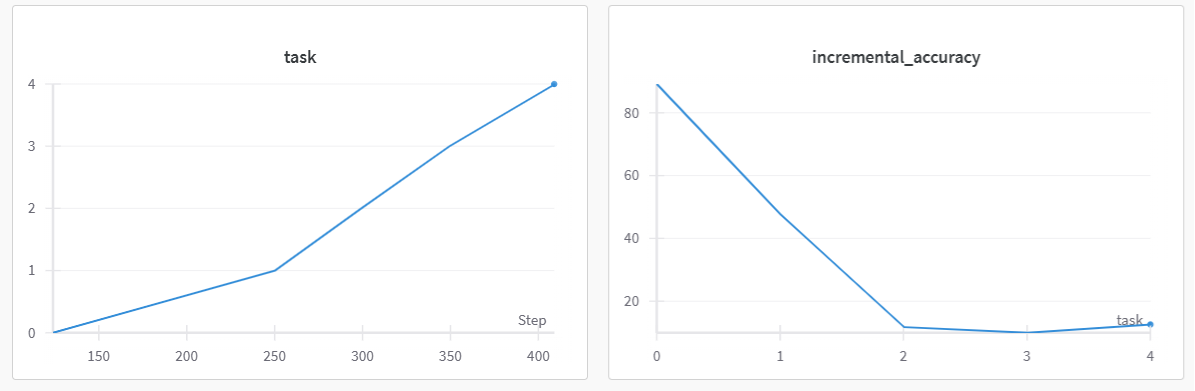

## Upper bound

### **Global and Per-Task Upper Bound Evaluation**

This section computes the **upper bound accuracy** for the GTSRB dataset by training the model with **all available data and all classes**.

#### **1. Global Upper Bound (All Data, All Classes)**
- **One-task training (`incremental_learning`)**:  
  - The model is trained in **one task** using **all classes** in the dataset.  
  - This provides an **upper bound** on accuracy when **all data is available at once** instead of incrementally.  
  - **5 epochs** are used for more stable results.
- **Copy Pre-trained Model**: A **deep copy** (`copy.deepcopy(copy_model)`) ensures the model starts from the same initialized state.  
- **Final Accuracy**: The computed accuracy serves as the **best possible performance** in a non-incremental setting.

#### **2. Upper Bound for Each Task (Non-Incremental Learning)**
- **Initialize a WandB Run**:  
  - The experiment is logged in **Weights & Biases (WandB)** with the project name `"GTSRB-CIL"` and run name `"Upper bound"`.  
  - Hyperparameters such as `epochs`, `batch_size`, `num_tasks`, `classes_per_task`, and `lr` are stored for tracking.

- **Non-Incremental Learning (`incremental_learning_wandb`)**:  
  - The model learns **all available data from all tasks** at every step (**non-incremental learning**).  
  - This setup **simulates a perfect scenario** where data is **not constrained by incremental learning limitations**.
  - This approach provides a **task-wise upper bound** for comparison.

#### **3. Logging and Finalization**
- **WandB logs incremental accuracy results** for visualization.  
- **`wandb.finish()` ensures proper experiment closure** and logs results effectively.  

This section provides **benchmark accuracy values**, helping compare incremental learning performance against **an ideal (upper-bound) setup**.  


In [16]:
#################################################
## Global upper bound (all data, all classes)
####

# One task + all classes computed using 5 epochs

model = copy.deepcopy(copy_model)
accu = incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                      1, (numclasses // num_tasks) * num_tasks, batch_size, 5, lr, device)

print(f"!!!!! Upper bound of accuracy = {accu[0]:.2f}%")


Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


100%|█████████████████████████████████████████| 407/407 [00:13<00:00, 30.78it/s]


Task 1, Epoch 1: Accuracy Train = 97.61%


100%|█████████████████████████████████████████| 407/407 [00:13<00:00, 31.11it/s]


Task 1, Epoch 2: Accuracy Train = 99.42%


100%|█████████████████████████████████████████| 407/407 [00:12<00:00, 31.31it/s]


Task 1, Epoch 3: Accuracy Train = 99.40%


100%|█████████████████████████████████████████| 407/407 [00:13<00:00, 31.16it/s]


Task 1, Epoch 4: Accuracy Train = 99.75%


100%|█████████████████████████████████████████| 407/407 [00:12<00:00, 31.57it/s]


Task 1, Epoch 5: Accuracy Train = 99.20%


100%|█████████████████████████████████████████| 194/194 [00:05<00:00, 32.37it/s]

Task 1: Accuracy Test = 89.41%
!!!!! Upper bound of accuracy = 89.41%


In [17]:
########################################
## Upper bound for each task (takes some time)
####
# initialise a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name = "Upper bound",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        })

# Non incremental data (learn all classes from all data for each task)
model = copy.deepcopy(copy_model)
incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                      num_tasks, classes_per_task, batch_size, num_epochs, lr, device, non_incremental = True)

wandb.finish()

Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7]


Epoch 0: 125it [00:04, 28.32it/s]
100%|█████████████████████████████████████████| 125/125 [00:03<00:00, 33.96it/s]


Task 1, Epoch 1: Accuracy Train = 58.70%


100%|███████████████████████████████████████████| 61/61 [00:01<00:00, 35.14it/s]


Task 1: Accuracy Test = 46.12%
Starting Task 2 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Epoch 0: 250it [00:09, 27.30it/s]
100%|█████████████████████████████████████████| 250/250 [00:07<00:00, 33.24it/s]


Task 2, Epoch 1: Accuracy Train = 88.41%


100%|█████████████████████████████████████████| 122/122 [00:04<00:00, 26.51it/s]


Task 2: Accuracy Test = 79.40%
Starting Task 3 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


Epoch 0: 299it [00:10, 29.89it/s]
100%|█████████████████████████████████████████| 299/299 [00:09<00:00, 30.81it/s]


Task 3, Epoch 1: Accuracy Train = 91.16%


100%|█████████████████████████████████████████| 144/144 [00:04<00:00, 33.23it/s]


Task 3: Accuracy Test = 80.02%
Starting Task 4 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


Epoch 0: 348it [00:12, 28.25it/s]
100%|█████████████████████████████████████████| 348/348 [00:11<00:00, 30.20it/s]


Task 4, Epoch 1: Accuracy Train = 93.02%


100%|█████████████████████████████████████████| 167/167 [00:05<00:00, 32.95it/s]


Task 4: Accuracy Test = 81.00%
Starting Task 5 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


Epoch 0: 407it [00:14, 28.31it/s]
100%|█████████████████████████████████████████| 407/407 [00:13<00:00, 31.00it/s]


Task 5, Epoch 1: Accuracy Train = 96.11%


100%|█████████████████████████████████████████| 194/194 [00:06<00:00, 27.79it/s]

Task 5: Accuracy Test = 84.44%


incremental_accuracy,▁▇▇▇█
task,▁▃▅▆█
train/train_loss,▅▄▃▆▄▃▂▂▂▇▇▅▅▅▄█▆▄▄▃▃▃▂▂▂▂▂▁█▆▆▄▂▂▂▂▁▂▂▁
incremental_accuracy,84.43906
task,4
train/train_loss,0.27145


The upper bound curve below represents the ideal performance achievable when all data is available from the start (non-incremental learning).

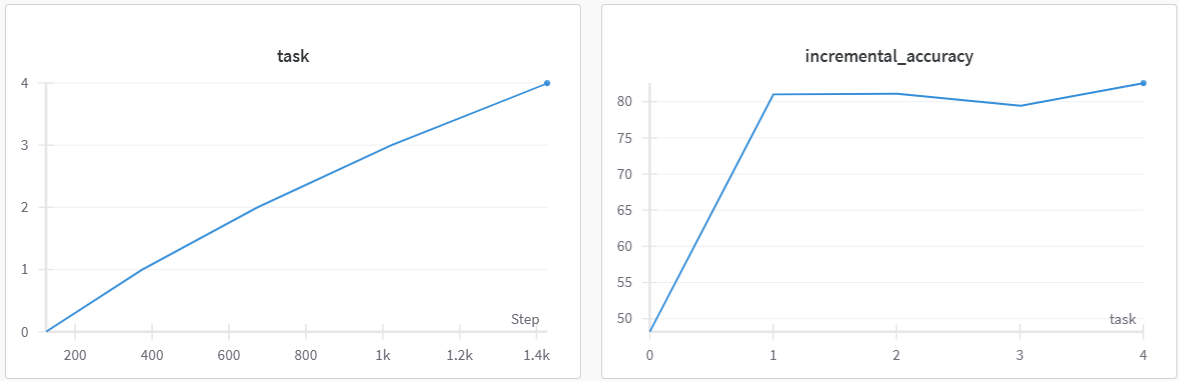

## Memory buffer

### **Memory Buffer for Incremental Learning**
In **class-incremental learning**, previous task data is often unavailable due to memory constraints.  
To mitigate **catastrophic forgetting**, we implement a **replay buffer** (Memory Buffer) that stores and reuses past data.

#### **1. Memory Buffer (`MemoryBuffer` Class)**
- **Purpose**:  
  - Stores a limited number of past examples for **experience replay**.  
  - Ensures that old knowledge is **not completely lost** as new tasks arrive.

- **Attributes:**
  - `buffer_size`: Defines the **maximum number** of stored examples.
  - `buffer`: A **list** that holds past training examples.

#### **2. Adding New Examples (`add_examples` method)**
- **Extends** the buffer by adding new training examples.
- **Maintains a fixed size**:
  - If the buffer **exceeds its limit**, the **oldest examples are discarded**.
  - Ensures that only the **most recent buffer_size examples** are kept.

#### **3. Retrieving Stored Examples (`get_examples` method)**
- Returns the **current stored examples** to be **used during training**.  

This **experience replay mechanism** helps in **stabilizing learning**, preventing the model from **forgetting earlier tasks** while adapting to new ones.


In [18]:
class MemoryBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = []

    def add_examples(self, examples):
        self.buffer.extend(examples)
        if len(self.buffer) > self.buffer_size:
            self.buffer = self.buffer[-self.buffer_size:]

    def get_examples(self):
        return self.buffer


## Knowledge Distillation

### **Knowledge Distillation for Incremental Learning**
In **class-incremental learning**, newly learned information can cause the model to **forget previous knowledge**.  
To address this, we use **Knowledge Distillation (KD)**, a technique where the model retains knowledge from older tasks while learning new ones.

#### **1. Distillation Loss Function (`distillation_loss`)**
- This function ensures that the model's **new predictions** remain **consistent** with its **old knowledge**.
- It computes the **Kullback-Leibler (KL) divergence** between:
  - The **new model's soft predictions** (`new_outputs`)
  - The **old model's soft predictions** (`old_outputs`)

#### **2. Handling Output Size Differences**
- When new tasks introduce **more classes**, the old model's output layer has **fewer neurons**.
- To match dimensions:
  - **Padding with zeros** ensures that `old_outputs` has the same shape as `new_outputs`.

#### **3. Softening Predictions with Temperature Scaling**
- The function applies **softmax with temperature (`T`)**:
  - **Higher `T`** → Produces **smoother probability distributions**.
  - This helps the model **transfer knowledge more effectively** by retaining information from past tasks.

#### **4. KL-Divergence for Knowledge Transfer**
- **KL-divergence** measures how much the new predictions **deviate** from the old ones.
- It ensures that the model does not **drastically change** its past outputs while learning new tasks.

This technique **helps prevent catastrophic forgetting** by encouraging **incremental adaptation** while preserving previously learned concepts.

In [19]:
def distillation_loss(new_outputs, old_outputs, temperature):
    # Pad old_outputs to match the size of new_outputs
    if old_outputs.size(1) < new_outputs.size(1):
        padding = torch.zeros(new_outputs.size(0), new_outputs.size(1) - old_outputs.size(1)).to(old_outputs.device)
        old_outputs = torch.cat((old_outputs, padding), dim=1)

    soft_new_outputs = F.softmax(new_outputs / temperature, dim=1)
    soft_old_outputs = F.softmax(old_outputs / temperature, dim=1)
    return F.kl_div(soft_new_outputs.log(), soft_old_outputs, reduction='batchmean')

## Training with KD METHOD 1

### **Incremental Learning with Knowledge Distillation (KD) and Rehearsal**
In **class-incremental learning**, models struggle with **catastrophic forgetting**—losing previous knowledge when learning new classes.  
To combat this, we use:
- **Knowledge Distillation (KD)**: Transfers knowledge from the previous model to the current one.
- **Rehearsal (Memory Buffer)**: Stores and reuses past examples to reinforce old knowledge.


### **1. Training Function (`train_incremental`)**
#### 🔹 **What happens during training?**
1. **New Data Training**:
   - The model is trained on new task data using **cross-entropy loss**.
  
2. **Knowledge Distillation**:
   - If an **old model** exists, we compute **KD loss** using `distillation_loss()`, ensuring the new model’s outputs remain consistent with the old model’s knowledge.
   - This prevents abrupt shifts in the learned representations.
  
3. **Rehearsal with Memory Buffer**:
   - If a **memory buffer** is available, past examples are replayed alongside new ones.
   - This helps reinforce previously learned concepts.

4. **Loss Computation & Optimization**:
   - The total loss is a sum of:
     - Standard classification loss
     - **KD loss** (to retain old knowledge)
     - **Rehearsal loss** (to reinforce past examples)
   - The optimizer updates the model weights accordingly.

5. **Updating Memory Buffer**:
   - The new examples are added to the **memory buffer**, ensuring the model has access to past experiences.

6. **Logging Training Metrics**:
   - We log the overall **loss**, **KD loss**, and **rehearsal loss** using `wandb.log()` for monitoring.


### **2. Incremental Learning Process (`incremental_learning_wandb`)**
- The model learns **incrementally** over multiple tasks.
- Each task contains a subset of the total classes.
- The model’s output layer **expands dynamically** to accommodate new classes.

#### 🔹 **Key Steps in Incremental Learning**
1. **Memory Buffer Initialization**:
   - Stores **past examples** for rehearsal.

2. **Task-based Training**:
   - If `non_incremental=True`, the model is trained on all available data up to the current task.
   - Otherwise, only new task classes are added.

3. **Adapting the Output Layer**:
   - The model’s classifier is expanded to handle new classes.
   - Previous weights and biases are **retained** to minimize forgetting.

4. **Training with Knowledge Distillation + Rehearsal**:
   - Each task is trained using `train_incremental()`, ensuring:
     - **New knowledge is acquired**.
     - **Old knowledge is retained** using KD.
     - **Memory buffer reinforces past knowledge**.

5. **Model Evaluation & Logging**:
   - After training on each task, we evaluate and log:
     - **Train accuracy** per epoch.
     - **Validation accuracy**.
     - **Incremental accuracy** across tasks.

6. **Updating the Old Model**:
   - After each task, the current model is **copied** and set to **evaluation mode**.
   - This ensures that in the next iteration, KD can effectively transfer knowledge.


### Why Use KD + Rehearsal?
**Mitigates Catastrophic Forgetting**: By **transferring old knowledge** while learning new tasks.  
**Balances Stability and Plasticity**: Ensures **new learning** doesn’t override previous knowledge.  
**Scalable to Many Tasks**: Works effectively as the number of tasks **increases over time**.  

This method provides an effective **incremental learning strategy** for **class-incremental deep learning models**.


In [20]:
def train_incremental(model, new_data_loader, memory_buffer, old_model, optimizer, criterion, temperature, device):
    model.train()
    for images, labels in new_data_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        optimizer.zero_grad()

        # Forward pass for new data
        new_outputs = model(images)
        loss = criterion(new_outputs, labels)

        # Initialize losses as tensors
        kd_loss = torch.tensor(0.0).to(device)
        rehearsal_loss = torch.tensor(0.0).to(device)

        # Knowledge Distillation
        if old_model:
            old_outputs = old_model(images.to(device))  # Ensure old model is on the same device
            kd_loss = distillation_loss(new_outputs, old_outputs, temperature)
            loss += kd_loss

        # Rehearsal
        if memory_buffer:
            memory_examples = memory_buffer.get_examples()
            if memory_examples:
                mem_images, mem_labels = zip(*memory_examples)
                mem_images = torch.stack(mem_images).to(device)  # Move rehearsal data to the same device
                mem_labels = torch.tensor(mem_labels).to(device)
                mem_outputs = model(mem_images)
                rehearsal_loss = criterion(mem_outputs, mem_labels)
                loss += rehearsal_loss

        loss.backward()
        optimizer.step()

        # Add new examples to memory buffer
        memory_buffer.add_examples(list(zip(images.cpu(), labels.cpu())))  # Store examples on CPU

        # Log training metrics to wandb
        wandb.log({"loss": loss.item(), "kd_loss": kd_loss.item(), "rehearsal_loss": rehearsal_loss.item()})

In [21]:
# Main training loop for incremental learning with Rehearsal + KD
def incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                               num_tasks, classes_per_task, batch_size, num_epochs, lr, device,
                               buffer_size=200, temperature=2.0, non_incremental=False):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    current_classes = []
    accuracies = []
    memory_buffer = MemoryBuffer(buffer_size)
    old_model = None

    # Copy your config
    config = wandb.config

    wandb.define_metric("task")
    wandb.define_metric("incremental_accuracy", step_metric="task")

    for task in range(num_tasks):
        if non_incremental:  # Learn from all available data
            task_classes = all_classes[0: (task + 1) * classes_per_task]
            current_classes = task_classes
            model.apply(initialize_weights)
        else:
            task_classes = all_classes[task * classes_per_task: (task + 1) * classes_per_task]
            current_classes.extend(task_classes)

        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle=True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle=False)

        if task == 0 or non_incremental:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        for epoch in range(num_epochs):  # Adjust number of epochs
            train_incremental(model, train_loader, memory_buffer, old_model, optimizer, criterion, temperature, device)
            scheduler.step()
            accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy:.2f}%")

            val_metrics = {"val/val_accuracy": accuracy}
            wandb.log({**val_metrics})

        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")

        incremental_metrics = {"incremental_accuracy": accuracy, "task": task}
        wandb.log({**incremental_metrics})

        # Update old model for KD
        old_model = copy.deepcopy(model)
        old_model.eval()

    return accuracies

## Logging in wandb

### **Logging Incremental Learning with WandB (Rehearsal + KD)**
We use **Weights & Biases (WandB)** to **log and monitor** the training process in incremental learning with **Rehearsal and Knowledge Distillation (KD)**.

### **1. Initializing WandB**
We start by **initializing a new WandB run**:

🔹 **Project Name**: `"GTSRB-CIL"`  
🔹 **Experiment Name**: `"Rehearsal + KD"`  
🔹 **Logged Hyperparameters**:
   - `epochs`: Number of training epochs
   - `batch_size`: Number of images per batch
   - `num_tasks`: Number of tasks in incremental learning
   - `classes_per_task`: Number of new classes added per task
   - `lr`: Learning rate
   - `buffer_size`: Size of the rehearsal memory buffer
   - `temperature`: Temperature scaling for knowledge distillation


### **2. Training with Incremental Learning + KD**
- We create a **deep copy** of the initial model to ensure the same starting point.
- The `incremental_learning_wandb()` function is called to:
  - Train the model **incrementally** over multiple tasks.
  - Use **Rehearsal (Memory Buffer)** to replay past examples.
  - Apply **Knowledge Distillation (KD)** to retain previous knowledge.
  - Log key **metrics** in WandB.


### **3. Finishing the WandB Run**
Once training is complete, we call `wandb.finish()` to properly close the logging session.


### Why Log with WandB?
**Live Monitoring**: Track training progress in real-time.  
**Hyperparameter Tracking**: Easily compare different experimental settings.  
**Visualization**: Generate plots for accuracy, loss, and other metrics.  

By integrating WandB, we can **effectively track the performance of incremental learning strategies** and analyze improvements.


In [22]:
temperature= 2
run = wandb.init(
    project="GTSRB-CIL",
    name="Rehearsal + KD",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        "buffer_size": buffer_size,
        "temperature": temperature,
    })

model = copy.deepcopy(copy_model)
incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                           num_tasks, classes_per_task, batch_size, num_epochs, lr, device,
                           buffer_size=buffer_size, temperature=temperature, non_incremental=False)
wandb.finish()

Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7]


100%|█████████████████████████████████████████| 125/125 [00:04<00:00, 26.96it/s]


Task 1, Epoch 1: Accuracy Train = 97.25%


100%|███████████████████████████████████████████| 61/61 [00:01<00:00, 31.30it/s]


Task 1: Accuracy Test = 89.07%
Starting Task 2 - Training on classes: [8, 9, 10, 11, 12, 13, 14, 15]


100%|█████████████████████████████████████████| 126/126 [00:04<00:00, 29.68it/s]


Task 2, Epoch 1: Accuracy Train = 99.50%


100%|█████████████████████████████████████████| 122/122 [00:04<00:00, 28.17it/s]


Task 2: Accuracy Test = 65.78%
Starting Task 3 - Training on classes: [16, 17, 18, 19, 20, 21, 22, 23]


100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 33.61it/s]


Task 3, Epoch 1: Accuracy Train = 99.42%


100%|█████████████████████████████████████████| 144/144 [00:04<00:00, 34.12it/s]


Task 3: Accuracy Test = 42.04%
Starting Task 4 - Training on classes: [24, 25, 26, 27, 28, 29, 30, 31]


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 25.12it/s]


Task 4, Epoch 1: Accuracy Train = 99.25%


100%|█████████████████████████████████████████| 167/167 [00:04<00:00, 34.21it/s]


Task 4: Accuracy Test = 24.34%
Starting Task 5 - Training on classes: [32, 33, 34, 35, 36, 37, 38, 39]


100%|███████████████████████████████████████████| 60/60 [00:01<00:00, 35.01it/s]


Task 5, Epoch 1: Accuracy Train = 99.79%


100%|█████████████████████████████████████████| 194/194 [00:06<00:00, 28.06it/s]

Task 5: Accuracy Test = 24.13%


incremental_accuracy,█▅▃▁▁
kd_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▅▆▅▅▆▆▆▅▅▅▄▁▅▃▄▅▄▄▄▄▄▄
loss,▆▂▂▁▂▁▁▁▁▁▁▁▁▁▆▄▄▄▃▃▃▃▃▃▃▄▄▃▃▃▃█▇▆▆▃▃▃█▂
rehearsal_loss,▃▂▂▁▁▁▄▃▄▃▂▁▂▁▁▁▁▁▃▂▂▁▂█▇▂▂▂▁▁▆▂▂▂▁▁▁▁▁▁
task,▁▃▅▆█
val/val_accuracy,▁▇▇▇█
incremental_accuracy,24.13236
kd_loss,0.3753
loss,0.66558
rehearsal_loss,0.13781
task,4


The image below demonstrates the performance when using a rehearsal memory buffer of size 200 combined with Knowledge Distillation, which helps in retaining knowledge of old classes while learning new ones.
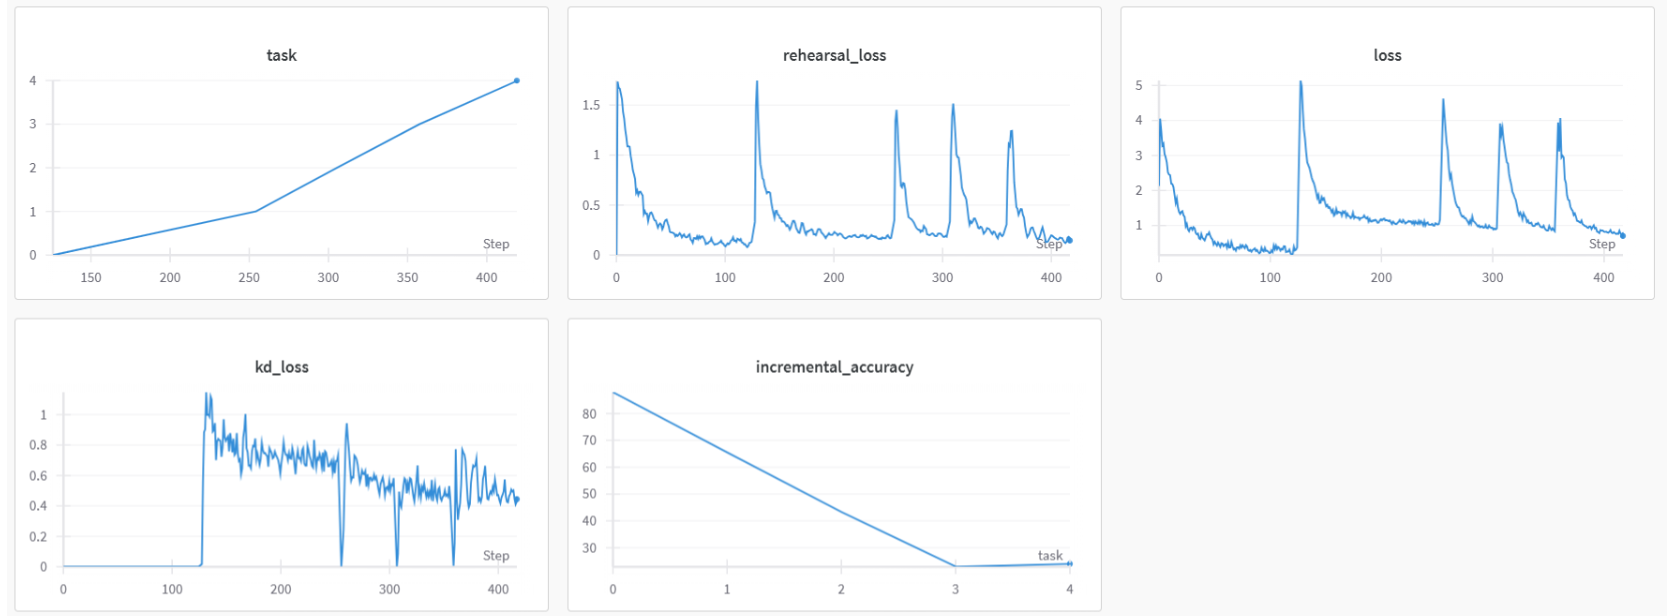

Below is a combined visualisation including all plots for fine tuning, upper bound and rehearsal+KD.

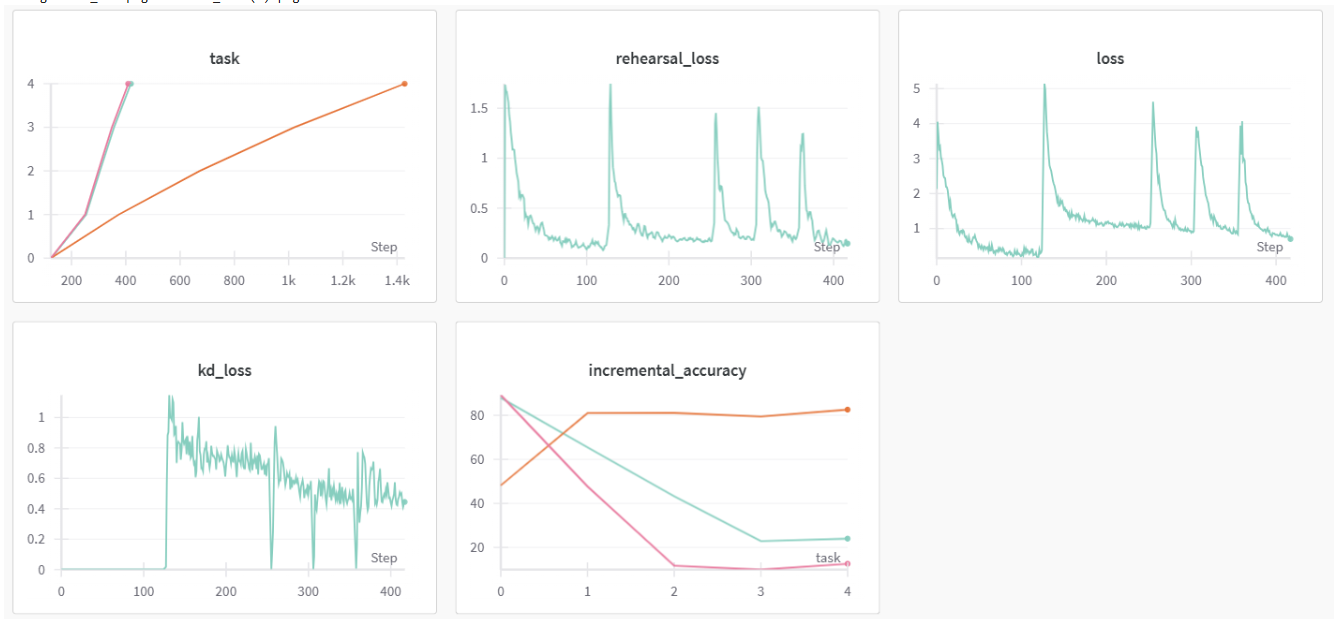


## Training with Rehersal METHOD 2


For the second method, we tried to use Algorithm from paper **"GDumb: A Simple Approach that Questions Our Progress in Continual Learning"** to add rehersal into our project

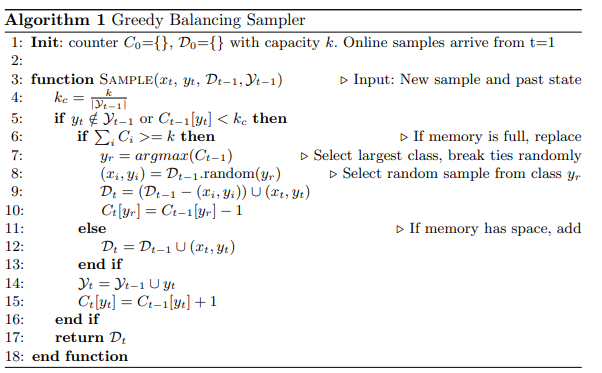

The rehearsal buffer strategy effectively balances computational efficiency and model performance in incremental learning. By replaying a small subset of past data, the model retains critical knowledge while adapting to new tasks. This approach provides a practical baseline for mitigating catastrophic forgetting and can be extended with more sophisticated sampling or generative techniques.


In [23]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset, TensorDataset

class TensorLabelDataset(Dataset):
    """Wrapper to ensure labels are tensors"""
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, torch.tensor(label, dtype=torch.long)

def incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                              num_tasks, classes_per_task, batch_size, num_epochs, lr, device,
                              non_incremental=False, buffer_size=200):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    current_classes = []
    accuracies = []

    # Initialize rehearsal buffer
    rehearsal_images = torch.tensor([])
    rehearsal_labels = torch.tensor([], dtype=torch.long)
    samples_per_task = buffer_size // num_tasks if buffer_size > 0 else 0

    # WandB initialization
    config = wandb.config
    wandb.define_metric("task")
    wandb.define_metric("incremental_accuracy", step_metric="task")

    for task in range(num_tasks):
        # Get task classes
        if non_incremental:
            task_classes = all_classes[0:(task+1)*classes_per_task]
            current_classes = task_classes
            model.apply(initialize_weights)
        else:
            task_classes = all_classes[task*classes_per_task:(task+1)*classes_per_task]
            current_classes.extend(task_classes)

        # Prepare training data with rehearsal
        current_indices = [i for i, label in enumerate(train_target) if label in task_classes]
        current_subset = Subset(train_dataset, current_indices)
        current_subset = TensorLabelDataset(current_subset)  # Convert to tensor labels

        # Collect samples for buffer
        if buffer_size > 0:
            current_loader = DataLoader(current_subset, batch_size=batch_size, shuffle=True)
            all_images, all_labels = [], []
            for img, lbl in current_loader:
                all_images.append(img.cpu())
                all_labels.append(lbl.cpu())

            if len(all_images) > 0:
                all_images = torch.cat(all_images)
                all_labels = torch.cat(all_labels)
                perm = torch.randperm(len(all_images))
                selected = perm[:samples_per_task]
                task_images = all_images[selected]
                task_labels = all_labels[selected]

                # Update rehearsal buffer
                rehearsal_images = torch.cat([rehearsal_images, task_images], dim=0)
                rehearsal_labels = torch.cat([rehearsal_labels, task_labels], dim=0)

                # Trim buffer if exceeds size
                if len(rehearsal_images) > buffer_size:
                    rehearsal_images = rehearsal_images[:buffer_size]
                    rehearsal_labels = rehearsal_labels[:buffer_size]

        # Create combined dataset
        if buffer_size > 0 and len(rehearsal_images) > 0:
            buffer_dataset = TensorDataset(rehearsal_images, rehearsal_labels)
            combined_dataset = ConcatDataset([current_subset, buffer_dataset])
        else:
            combined_dataset = current_subset

        train_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

        # Adjust model output layer
        if task == 0 or non_incremental:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias

        # Initialize optimizer
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        # Training loop
        print(f"Starting Task {task+1} - Classes: {task_classes}")
        for epoch in range(num_epochs):
            train_wandb(model, train_loader, optimizer, criterion, device, epoch)
            scheduler.step()
            train_acc = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Train Acc = {train_acc:.2f}%")

        # Evaluation
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, False)
        test_acc = evaluate(model, test_loader, device)
        accuracies.append(test_acc)
        print(f"Task {task+1} Test Accuracy: {test_acc:.2f}%")
        wandb.log({"incremental_accuracy": test_acc, "task": task})

    return accuracies

For the second method of the project, we implemented an **incremental learning** approach for a classification task using PyTorch. The goal is to train a model sequentially on different tasks while **retaining knowledge from previous tasks**. To achieve this, we use a **rehearsal buffer**, which stores past examples and helps the model remember previous classes. We also integrate **Weights & Biases (WandB)** for experiment tracking.

#### 🔹 **Key Steps in  Second Method**











### 1. Dataset Wrapping for Tensor Labels  
- Since some datasets may have labels in non-tensor formats, we define a custom dataset class, `TensorLabelDataset`, to ensure labels are converted to PyTorch tensors.

### 2. Defining the Incremental Learning Function  
- The function `incremental_learning_wandb` manages training across multiple tasks.  
- We **split the dataset into multiple tasks**, each containing a subset of classes.  
- We keep a **buffer of past samples** to help the model remember previous classes.

### 3. Rehearsal Buffer Mechanism  
- At each task, we store a limited number of past samples in a **rehearsal buffer**.
- The buffer size is controlled by `buffer_size`.
- The function ensures that the buffer does not exceed its allocated memory by trimming older samples.

### 4. Dataloader Preparation  
- For each task, we create a `DataLoader` that combines the current task's data with the rehearsal buffer.
- This helps the model learn new classes while **not forgetting old ones**.

### 5. Adjusting the Model’s Output Layer  
- Since the number of classes increases over time, we **dynamically modify the final layer** of the model to accommodate new classes.
- If it’s the first task, we initialize the classification layer. Otherwise, we expand it while keeping old weights.

### 6. Training with WandB Logging  
- The training process runs for `num_epochs` using an **Adam optimizer** and a **StepLR scheduler**.
- At each epoch, we train the model and **evaluate its performance on training data**.
- After each task, we evaluate the model on **test data containing all seen classes**.
- The test accuracy is logged to **Weights & Biases**.

### 7. Running the Experiment  
- We initialize WandB and train the model using the `incremental_learning_wandb` function.
- Finally, we call `wandb.finish()` to complete the experiment.

In [24]:
# Run with rehearsal buffer
run = wandb.init(project="GTSRB-CIL", name="Rehearsal")
model = SimpleCNN(n_in=3).to(device)
acc = incremental_learning_wandb(
    model=model,
    train_dataset=train_dataset,
    train_target=train_target,
    test_dataset=test_dataset,
    test_target=test_target,
    num_tasks=5,
    classes_per_task=8,
    batch_size=64,
    num_epochs=10,
    lr=1e-3,
    device=device,
    buffer_size=500  # Size of rehearsal buffer
)
wandb.finish()

Starting Task 1 - Classes: [0, 1, 2, 3, 4, 5, 6, 7]


Epoch 0: 126it [00:04, 30.04it/s]
100%|█████████████████████████████████████████| 126/126 [00:04<00:00, 28.00it/s]


Task 1, Epoch 1: Train Acc = 40.68%


Epoch 1: 126it [00:04, 26.83it/s]
100%|█████████████████████████████████████████| 126/126 [00:03<00:00, 32.05it/s]


Task 1, Epoch 2: Train Acc = 84.91%


Epoch 2: 126it [00:04, 27.85it/s]
100%|█████████████████████████████████████████| 126/126 [00:04<00:00, 27.04it/s]


Task 1, Epoch 3: Train Acc = 94.10%


Epoch 3: 126it [00:04, 30.16it/s]
100%|█████████████████████████████████████████| 126/126 [00:03<00:00, 33.08it/s]


Task 1, Epoch 4: Train Acc = 97.27%


Epoch 4: 126it [00:05, 23.80it/s]
100%|█████████████████████████████████████████| 126/126 [00:03<00:00, 32.75it/s]


Task 1, Epoch 5: Train Acc = 97.88%


Epoch 5: 126it [00:04, 29.72it/s]
100%|█████████████████████████████████████████| 126/126 [00:04<00:00, 26.68it/s]


Task 1, Epoch 6: Train Acc = 99.22%


Epoch 6: 126it [00:04, 28.33it/s]
100%|█████████████████████████████████████████| 126/126 [00:03<00:00, 33.19it/s]


Task 1, Epoch 7: Train Acc = 99.65%


Epoch 7: 126it [00:04, 26.63it/s]
100%|█████████████████████████████████████████| 126/126 [00:04<00:00, 27.96it/s]


Task 1, Epoch 8: Train Acc = 99.54%


Epoch 8: 126it [00:04, 30.02it/s]
100%|█████████████████████████████████████████| 126/126 [00:04<00:00, 31.32it/s]


Task 1, Epoch 9: Train Acc = 99.60%


Epoch 9: 126it [00:05, 24.23it/s]
100%|█████████████████████████████████████████| 126/126 [00:03<00:00, 32.83it/s]


Task 1, Epoch 10: Train Acc = 99.89%


100%|███████████████████████████████████████████| 61/61 [00:01<00:00, 34.85it/s]


Task 1 Test Accuracy: 89.22%
Starting Task 2 - Classes: [8, 9, 10, 11, 12, 13, 14, 15]


Epoch 0: 129it [00:05, 24.21it/s]
100%|█████████████████████████████████████████| 129/129 [00:03<00:00, 32.83it/s]


Task 2, Epoch 1: Train Acc = 97.98%


Epoch 1: 129it [00:04, 29.77it/s]
100%|█████████████████████████████████████████| 129/129 [00:05<00:00, 25.36it/s]


Task 2, Epoch 2: Train Acc = 99.21%


Epoch 2: 129it [00:04, 30.06it/s]
100%|█████████████████████████████████████████| 129/129 [00:03<00:00, 33.10it/s]


Task 2, Epoch 3: Train Acc = 99.72%


Epoch 3: 129it [00:05, 23.56it/s]
100%|█████████████████████████████████████████| 129/129 [00:03<00:00, 32.98it/s]


Task 2, Epoch 4: Train Acc = 99.90%


Epoch 4: 129it [00:04, 29.81it/s]
100%|█████████████████████████████████████████| 129/129 [00:04<00:00, 27.08it/s]


Task 2, Epoch 5: Train Acc = 99.95%


Epoch 5: 129it [00:04, 27.27it/s]
100%|█████████████████████████████████████████| 129/129 [00:03<00:00, 32.72it/s]


Task 2, Epoch 6: Train Acc = 99.99%


Epoch 6: 129it [00:04, 26.99it/s]
100%|█████████████████████████████████████████| 129/129 [00:04<00:00, 27.91it/s]


Task 2, Epoch 7: Train Acc = 99.99%


Epoch 7: 129it [00:04, 29.71it/s]
100%|█████████████████████████████████████████| 129/129 [00:04<00:00, 31.03it/s]


Task 2, Epoch 8: Train Acc = 99.98%


Epoch 8: 129it [00:05, 24.49it/s]
100%|█████████████████████████████████████████| 129/129 [00:03<00:00, 33.16it/s]


Task 2, Epoch 9: Train Acc = 100.00%


Epoch 9: 129it [00:04, 29.87it/s]
100%|█████████████████████████████████████████| 129/129 [00:05<00:00, 25.26it/s]


Task 2, Epoch 10: Train Acc = 99.96%


100%|█████████████████████████████████████████| 122/122 [00:03<00:00, 34.10it/s]


Task 2 Test Accuracy: 75.95%
Starting Task 3 - Classes: [16, 17, 18, 19, 20, 21, 22, 23]


Epoch 0: 54it [00:01, 31.36it/s]
100%|███████████████████████████████████████████| 54/54 [00:01<00:00, 34.13it/s]


Task 3, Epoch 1: Train Acc = 98.10%


Epoch 1: 54it [00:01, 27.68it/s]
100%|███████████████████████████████████████████| 54/54 [00:02<00:00, 24.97it/s]


Task 3, Epoch 2: Train Acc = 99.21%


Epoch 2: 54it [00:02, 25.07it/s]
100%|███████████████████████████████████████████| 54/54 [00:01<00:00, 34.72it/s]


Task 3, Epoch 3: Train Acc = 99.71%


Epoch 3: 54it [00:01, 31.79it/s]
100%|███████████████████████████████████████████| 54/54 [00:01<00:00, 34.43it/s]


Task 3, Epoch 4: Train Acc = 99.77%


Epoch 4: 54it [00:01, 31.44it/s]
100%|███████████████████████████████████████████| 54/54 [00:01<00:00, 34.47it/s]


Task 3, Epoch 5: Train Acc = 99.71%


Epoch 5: 54it [00:01, 28.46it/s]
100%|███████████████████████████████████████████| 54/54 [00:02<00:00, 25.37it/s]


Task 3, Epoch 6: Train Acc = 100.00%


Epoch 6: 54it [00:02, 24.98it/s]
100%|███████████████████████████████████████████| 54/54 [00:01<00:00, 34.83it/s]


Task 3, Epoch 7: Train Acc = 100.00%


Epoch 7: 54it [00:01, 31.39it/s]
100%|███████████████████████████████████████████| 54/54 [00:01<00:00, 35.09it/s]


Task 3, Epoch 8: Train Acc = 100.00%


Epoch 8: 54it [00:01, 31.30it/s]
100%|███████████████████████████████████████████| 54/54 [00:01<00:00, 34.84it/s]


Task 3, Epoch 9: Train Acc = 100.00%


Epoch 9: 54it [00:01, 28.24it/s]
100%|███████████████████████████████████████████| 54/54 [00:02<00:00, 25.48it/s]


Task 3, Epoch 10: Train Acc = 100.00%


100%|█████████████████████████████████████████| 144/144 [00:04<00:00, 30.61it/s]


Task 3 Test Accuracy: 69.49%
Starting Task 4 - Classes: [24, 25, 26, 27, 28, 29, 30, 31]


Epoch 0: 56it [00:01, 31.42it/s]
100%|███████████████████████████████████████████| 56/56 [00:01<00:00, 34.70it/s]


Task 4, Epoch 1: Train Acc = 96.40%


Epoch 1: 56it [00:01, 32.02it/s]
100%|███████████████████████████████████████████| 56/56 [00:02<00:00, 26.41it/s]


Task 4, Epoch 2: Train Acc = 98.85%


Epoch 2: 56it [00:02, 23.36it/s]
100%|███████████████████████████████████████████| 56/56 [00:01<00:00, 34.75it/s]


Task 4, Epoch 3: Train Acc = 99.75%


Epoch 3: 56it [00:01, 31.31it/s]
100%|███████████████████████████████████████████| 56/56 [00:01<00:00, 33.84it/s]


Task 4, Epoch 4: Train Acc = 99.94%


Epoch 4: 56it [00:01, 31.62it/s]
100%|███████████████████████████████████████████| 56/56 [00:01<00:00, 34.24it/s]


Task 4, Epoch 5: Train Acc = 99.83%


Epoch 5: 56it [00:01, 30.28it/s]
100%|███████████████████████████████████████████| 56/56 [00:02<00:00, 25.37it/s]


Task 4, Epoch 6: Train Acc = 100.00%


Epoch 6: 56it [00:02, 24.11it/s]
100%|███████████████████████████████████████████| 56/56 [00:01<00:00, 33.36it/s]


Task 4, Epoch 7: Train Acc = 100.00%


Epoch 7: 56it [00:01, 31.58it/s]
100%|███████████████████████████████████████████| 56/56 [00:01<00:00, 33.95it/s]


Task 4, Epoch 8: Train Acc = 100.00%


Epoch 8: 56it [00:01, 31.64it/s]
100%|███████████████████████████████████████████| 56/56 [00:01<00:00, 34.96it/s]


Task 4, Epoch 9: Train Acc = 100.00%


Epoch 9: 56it [00:02, 27.63it/s]
100%|███████████████████████████████████████████| 56/56 [00:02<00:00, 25.84it/s]


Task 4, Epoch 10: Train Acc = 100.00%


100%|█████████████████████████████████████████| 167/167 [00:05<00:00, 31.37it/s]


Task 4 Test Accuracy: 62.52%
Starting Task 5 - Classes: [32, 33, 34, 35, 36, 37, 38, 39]


Epoch 0: 67it [00:02, 32.72it/s]
100%|███████████████████████████████████████████| 67/67 [00:01<00:00, 35.33it/s]


Task 5, Epoch 1: Train Acc = 99.51%


Epoch 1: 67it [00:02, 25.16it/s]
100%|███████████████████████████████████████████| 67/67 [00:02<00:00, 27.23it/s]


Task 5, Epoch 2: Train Acc = 99.93%


Epoch 2: 67it [00:02, 32.35it/s]
100%|███████████████████████████████████████████| 67/67 [00:01<00:00, 35.44it/s]


Task 5, Epoch 3: Train Acc = 99.88%


Epoch 3: 67it [00:02, 32.38it/s]
100%|███████████████████████████████████████████| 67/67 [00:01<00:00, 35.59it/s]


Task 5, Epoch 4: Train Acc = 99.72%


Epoch 4: 67it [00:02, 30.00it/s]
100%|███████████████████████████████████████████| 67/67 [00:02<00:00, 26.53it/s]


Task 5, Epoch 5: Train Acc = 99.98%


Epoch 5: 67it [00:02, 28.18it/s]
100%|███████████████████████████████████████████| 67/67 [00:01<00:00, 36.45it/s]


Task 5, Epoch 6: Train Acc = 100.00%


Epoch 6: 67it [00:02, 32.24it/s]
100%|███████████████████████████████████████████| 67/67 [00:01<00:00, 35.95it/s]


Task 5, Epoch 7: Train Acc = 100.00%


Epoch 7: 67it [00:02, 32.25it/s]
100%|███████████████████████████████████████████| 67/67 [00:02<00:00, 30.36it/s]


Task 5, Epoch 8: Train Acc = 100.00%


Epoch 8: 67it [00:02, 23.72it/s]
100%|███████████████████████████████████████████| 67/67 [00:01<00:00, 34.58it/s]


Task 5, Epoch 9: Train Acc = 100.00%


Epoch 9: 67it [00:02, 32.06it/s]
100%|███████████████████████████████████████████| 67/67 [00:01<00:00, 35.01it/s]


Task 5, Epoch 10: Train Acc = 100.00%


100%|█████████████████████████████████████████| 194/194 [00:06<00:00, 31.31it/s]

Task 5 Test Accuracy: 66.88%


incremental_accuracy,█▅▃▁▂
task,▁▃▅▆█
train/train_loss,█▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁
incremental_accuracy,66.87651
task,4
train/train_loss,0.00043


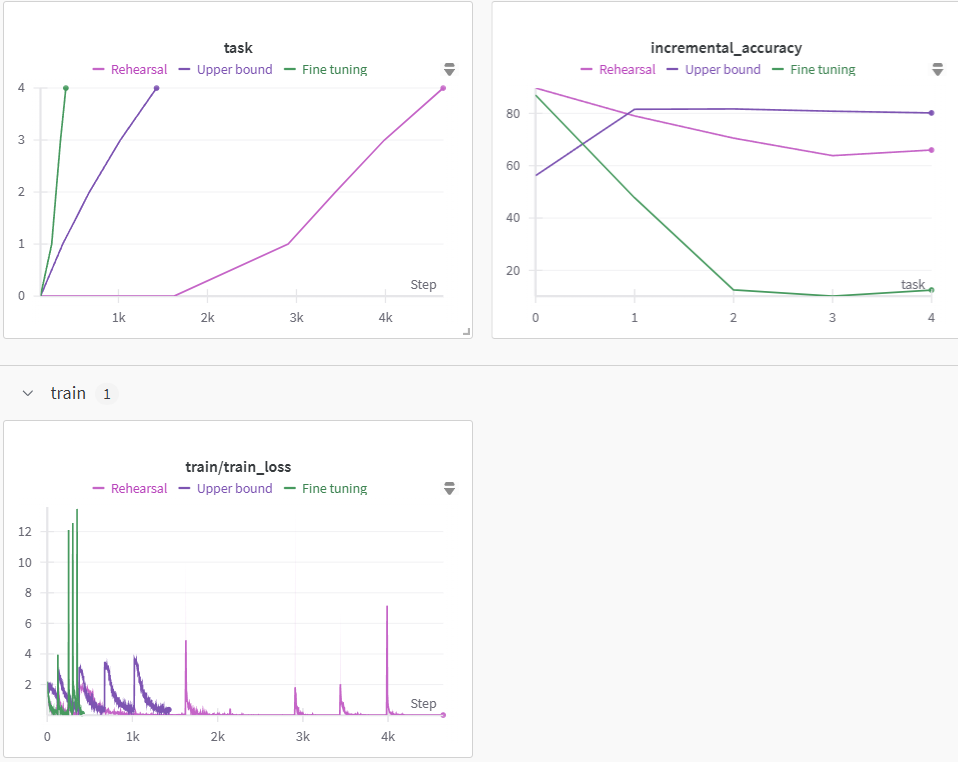